In [1]:
# https://github.com/tjwei/GANotebooks/blob/master/CycleGAN-keras.ipynb

import keras.backend as K
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02)
if K.image_data_format() == 'channels_first':
    channel_first = True
    channel_axis = 1
else:
    channel_first = False
    channel_axis = -1
print(K.image_data_format())
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def instance_norm(x):
    epsilon = 1e-9
    mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
    return tf.div(tf.sub(x, mean), tf.sqrt(tf.add(var, epsilon)))

def BASIC_D(nc_in, ndf, max_layers=3, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    _ = input_a = Input(shape=(None, None, nc_in))
    _ = Conv2D(ndf, kernel_size=4, strides=2, padding="same", kernel_initializer=conv_init) (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = Conv2D(out_feat, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=conv_init) (_)
        _ = BatchNormalization(momentum=0.9, axis=-1, epsilon=1.01e-5,
                               gamma_initializer = gamma_init)(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = Conv2D(out_feat, kernel_size=4, use_bias=False, kernel_initializer=conv_init) (_)
    _ = BatchNormalization(momentum=0.9, axis=-1, epsilon=1.01e-5,
                           gamma_initializer = gamma_init)(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    _ = ZeroPadding2D(1)(_)
    _ = Conv2D(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid" if use_sigmoid else None, kernel_initializer=conv_init) (_)    
    return Model(inputs=[input_a], outputs=_)

def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = Conv2D(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", kernel_initializer=conv_init) (x)
        if s>2:
            if use_batchnorm:
                x = BatchNormalization(momentum=0.9, axis=-1, epsilon=1.01e-5,
                                       gamma_initializer = gamma_init)(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init)(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

Using TensorFlow backend.


channels_last


In [8]:
OUTPUT_PATH = 'output_cyclegan_anime_celeba'

nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
use_lsgan = True
lamb = 10 if use_lsgan else 100

loadSize = 64
imageSize = 64
batchSize = 4
lrD = 2e-4
lrG = 2e-4

In [9]:
netDA = BASIC_D(nc_in, ndf, use_sigmoid = not use_lsgan)
netDB = BASIC_D(nc_out, ndf, use_sigmoid = not use_lsgan)
netDA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, None, None, 64)    3136      
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, None, None, 64)    0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, None, None, 128)   131072    
_________________________________________________________________
batch_normalization_21 (Batc (None, None, None, 128)   512       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, None, None, 128)   0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, None, None, 256)   524288    
__________

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

netGB = UNET_G(imageSize, nc_in, nc_out, ngf)
netGA = UNET_G(imageSize, nc_out, nc_in, ngf)
#SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))
netGA.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 32, 32, 64)   3136        input_12[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_50 (LeakyReLU)      (None, 32, 32, 64)   0           conv2d_53[0][0]                  
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 16, 16, 128)  131072      leaky_re_lu_50[0][0]             
__________________________________________________________________________________________________
batch_norm

In [12]:
from os import mkdir
from os.path import join, exists
if not exists(OUTPUT_PATH): mkdir(OUTPUT_PATH)

# Save networks (netDA, netDB, netGA, netDB)
def save(name, nets):
    netDA, netDB, netGA, netDB = nets
    netDA.save_weights(join(OUTPUT_PATH, '{0}.DA.h5'.format(name)))
    netDB.save_weights(join(OUTPUT_PATH, '{0}.DB.h5'.format(name)))
    netGA.save_weights(join(OUTPUT_PATH, '{0}.GA.h5'.format(name)))
    netGB.save_weights(join(OUTPUT_PATH, '{0}.GB.h5'.format(name)))
# Load networks (netDA, netDB, netGA, netDB)
def load(name, nets):
    netDA, netDB, netGA, netDB = nets
    netDA.load_weights(join(OUTPUT_PATH, '{0}.DA.h5'.format(name)))
    netDB.load_weights(join(OUTPUT_PATH, '{0}.DB.h5'.format(name)))
    netGA.load_weights(join(OUTPUT_PATH, '{0}.GA.h5'.format(name)))
    netGB.load_weights(join(OUTPUT_PATH, '{0}.GB.h5'.format(name)))
# load('cyclegan', (netDA, netDB, netGA, netDB))

In [13]:
from keras.optimizers import RMSprop, SGD, Adam

if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

def cycle_variables(netG1, netG2):
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]
    rec_input = netG2([fake_output])
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate

real_A, fake_B, rec_A, cycleA_generate = cycle_variables(netGB, netGA)
real_B, fake_A, rec_B, cycleB_generate = cycle_variables(netGA, netGB)

In [14]:
def D_loss(netD, real, fake, rec):
    output_real = netD([real])
    output_fake = netD([fake])
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    loss_D = loss_D_real+loss_D_fake
    loss_cyc = K.mean(K.abs(rec-real))
    return loss_D, loss_G, loss_cyc

loss_DA, loss_GA, loss_cycA = D_loss(netDA, real_A, fake_A, rec_A)
loss_DB, loss_GB, loss_cycB = D_loss(netDB, real_B, fake_B, rec_B)
loss_cyc = loss_cycA+loss_cycB

loss_G = loss_GA+loss_GB+lamb*loss_cyc
loss_D = loss_DA+loss_DB

weightsD = netDA.trainable_weights + netDB.trainable_weights
weightsG = netGA.trainable_weights + netGB.trainable_weights

training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_DA/2, loss_DB/2], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsG,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_GA, loss_GB, loss_cyc], training_updates)

In [15]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)

def load_data_with_labels(file_pattern, labels=[]):
    data = []
    tags_list = []
    with open('data/tags_clean.csv', 'r') as f:
        tags_list.extend([[x.split(':')[0].strip() for x in line.strip().split(',')[1].split('\t') if x] for line in f.readlines()])
    for idx, tags in enumerate(tags_list):
        if any(label in tags for label in labels):
            data.append(file_pattern.format(idx))
    return data

def read_image(fn):
    im = Image.open(fn).convert('RGB')
    im = im.resize( (loadSize, loadSize), Image.BILINEAR )
    arr = np.array(im).astype(float)/255*2-1
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    img = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    return img



train_A = load_data('faces/*.jpg')
train_B = load_data('celeba/*.jpg')


In [16]:
#  train_B

In [17]:
def minibatch(data, batchsize):
    length = len(data)
    epoch = i = 0
    tmpsize = None
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1
        rtn = [read_image(data[j]) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)

def minibatchAB(dataA, dataB, batchsize):
    batchA=minibatch(dataA, batchsize)
    batchB=minibatch(dataB, batchsize)
    tmpsize = None
    while True:
        ep1, A = batchA.send(tmpsize)
        ep2, B = batchB.send(tmpsize)
        tmpsize = yield max(ep1, ep2), A, B

In [18]:
from IPython.display import display
def showX(X, rows=1, save=None):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
#     int_X = ( (X+1)/2*255).astype('uint8')
    
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    image = Image.fromarray(int_X)
    display(image)
    if save is not None: image.save(join(OUTPUT_PATH, save))
def print_and_log(msg):
    print(msg)
    with open(join(OUTPUT_PATH, 'output.log'), 'a') as f:
        f.write('{0}\n'.format(msg))

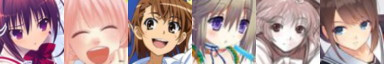

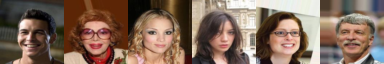

In [19]:
train_batch = minibatchAB(train_A, train_B, 6)

_, A, B = next(train_batch)
showX(A, save='sample-A.jpg')
showX(B, save='sample-B.jpg')
del train_batch, A, B

In [20]:
# train_batch = minibatchAB(train_A, train_B, 6)
# _, A, B = next(train_batch)

In [21]:
# im = Image.open('faces_bw/0.jpg').convert('RGB')

In [22]:
# im.resize( (loadSize, loadSize), Image.BILINEAR )

In [23]:
# np.array(im).astype(float)/255*2-1

In [24]:
def showG(A, B, save=None):
    assert A.shape==B.shape
    def G(fn_generate, X):
        r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
        return r.swapaxes(0,1)[:,:,0]        
    rA = G(cycleA_generate, A)
    rB = G(cycleB_generate, B)
    arr = np.concatenate([A,B,rA[0],rB[0],rA[1],rB[1]])
    showX(arr, 3, save)

('[14/150][120150] Loss_D: 0.026410 0.036172 Loss_G: 1.033295 1.014198 loss_cyc 0.169810', 21862.25546193123)


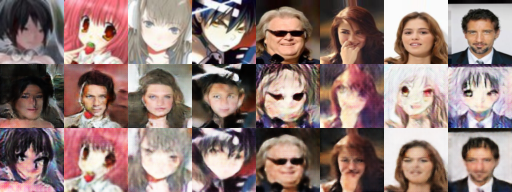

KeyboardInterrupt: 

In [25]:
import time
from IPython.display import clear_output
t0 = time.time()
niter = 150
gen_iterations = 0
epoch = 0
errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

display_iters = 50
#val_batch = minibatch(valAB, 6, direction)
train_batch = minibatchAB(train_A, train_B, batchSize)

while epoch < niter: 
    epoch, A, B = next(train_batch)        
    errDA, errDB  = netD_train([A, B])
    errDA_sum +=errDA
    errDB_sum +=errDB

    # epoch, trainA, trainB = next(train_batch)
    errGA, errGB, errCyc = netG_train([A, B])
    errGA_sum += errGA
    errGB_sum += errGB
    errCyc_sum += errCyc
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        #if gen_iterations%(5*display_iters)==0:
        clear_output()
        print('[%d/%d][%d] Loss_D: %f %f Loss_G: %f %f loss_cyc %f'
        % (epoch, niter, gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
           errGA_sum/display_iters, errGB_sum/display_iters, 
           errCyc_sum/display_iters), time.time()-t0)
        _, A, B = train_batch.send(4)
        showG(A,B,save=str(gen_iterations)+'.jpg')        
        errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0